<a href="https://colab.research.google.com/github/gggggeun/study/blob/main/2.%20%EB%B6%84%EB%A5%98%EC%9D%98%20%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C%EB%93%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정밀도&재현율 Trade-off 와 Threshold(임계값) 조정

In [ ]:
import pandas as pd
from google.colab import files
files.upload()

In [ ]:
# 타이타닉 데이터 불러오기
df = pd.read_csv('train (1).csv')

In [ ]:
# 필요없는 feature 제거
df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
# 결측값 정리
df['Age'].fillna(df['Age'].mean(),inplace=True)
df['Cabin'].fillna('N', inplace=True)
df['Embarked'].fillna('N', inplace=True)
print('총 결측치 수:',df.isnull().sum().sum())
# 문자열 정리
df['Cabin'] = df['Cabin'].str[:1]
# 인코딩
from sklearn import preprocessing
def encode_features(dataDF):
  features = ['Cabin','Sex','Embarked']
  for feature in features :
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])
  return dataDF
df = encode_features(df)
df.head(3)

총 결측치 수: 0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,3


In [ ]:
# 평가지표들 함수만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred) :
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy,precision,recall))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 타이타닉 데이터 분할/학습/예측/평가
target = df['Survived']
features = df.drop('Survived', axis=1)
X_train, X_test,y_train, y_test = train_test_split(features, target, 
                                                   test_size=0.2, random_state=10)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[101  16]
 [ 15  47]]
정확도:0.8268, 정밀도:0.7460, 재현율:0.7581


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Probability

In [ ]:
# 예측확률(prediction probability)
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))

# 예측확률 array와 예측 결괏값 array를 병합(concatenate)하고 DF으로 예측 확률과 결괏값을 한눈에 확인
import numpy as np
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
data = pd.DataFrame(pred_proba_result)
data.rename(columns={0:'probability of Negative(0)',1 : 'probability of Positive(1)', 2:'predict'}, inplace=True)
data

pred_proba()결과 Shape : (179, 2)


,probability of Negative(0),probability of Positive(1),predict
0,0.906444,0.093556,0.0
1,0.853763,0.146237,0.0
2,0.877215,0.122785,0.0
3,0.073293,0.926707,1.0
4,0.106458,0.893542,1.0
...,...,...,...
174,0.785140,0.214860,0.0
175,0.700834,0.299166,0.0
176,0.929178,0.070822,0.0
177,0.956121,0.043879,0.0


# Binarizer 클래스로 threshold 이해하기

In [ ]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


# Binarizer로 predcit()의 의사코드(pseudo code) 만들고 임곗값 조절하기

In [ ]:
# Binarizer의 threshold 설정값. =분류 결정 임곗값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

print('threshold :',custom_threshold,'\n')
get_clf_eval(y_test, custom_predict)

threshold : 0.5 

오차행렬
[[101  16]
 [ 15  47]]
정확도:0.8268, 정밀도:0.7460, 재현율:0.7581


In [ ]:
# threshold 낮춰보기
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

print('threshold :',custom_threshold,'\n')
get_clf_eval(y_test, custom_predict)

threshold : 0.4 

오차행렬
[[95 22]
 [13 49]]
정확도:0.8045, 정밀도:0.6901, 재현율:0.7903


Threshold를 낮추니 정밀도는 떨어지고 재현율은 올랐다.
분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 된다. (임곗값의 이상은 Positive 이하는 Negative이다.)
확률을 0.4부터 Positive로 예측을 더 너그럽게 하기 때문에 임곗값을 낮출수록 Positive True 값이 많아지게 된다. 

임계값이 0.5인 오차행렬과 0.4인 오차행렬을 비교해보면, 임계값을 낮추니 Positive가 많아져 FP(0,1)와 TP(1,1)가 늘어났다. 반대로 Negative인 TN(0,0)과 FN(1,0)은 떨어졌다. 

- TP가 47에서 49로 오름
- FP가 16에서 22로 오름 -> 재현율이 75%에서 79%로 오름
- TN가 101에서 95로 떨어짐
- FN이 15에서 13으로 떨어짐 -> 정밀도가 74%에서 69%로 떨어짐

In [ ]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print("\n임곗값 :", custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값 : 0.4
오차행렬
[[95 22]
 [13 49]]
정확도:0.8045, 정밀도:0.6901, 재현율:0.7903

임곗값 : 0.45
오차행렬
[[97 20]
 [14 48]]
정확도:0.8101, 정밀도:0.7059, 재현율:0.7742

임곗값 : 0.5
오차행렬
[[101  16]
 [ 15  47]]
정확도:0.8268, 정밀도:0.7460, 재현율:0.7581

임곗값 : 0.55
오차행렬
[[103  14]
 [ 19  43]]
정확도:0.8156, 정밀도:0.7544, 재현율:0.6935

임곗값 : 0.6
오차행렬
[[107  10]
 [ 20  42]]
정확도:0.8324, 정밀도:0.8077, 재현율:0.6774


- 재현율을 향상 시키면서 다른 수치를 어느 정도 감소 : 임곗값 0.45

In [ ]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측확률
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape :', thresholds.shape)

# 반환된 임계값 배열 로우가 162건이므로 샘플로 10건만 추출하되, 임계값을 16 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 16)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값 :', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape : (162,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  16  32  48  64  80  96 112 128 144 160]
샘플용 10개의 임곗값 : [0.04 0.08 0.11 0.14 0.16 0.28 0.47 0.61 0.73 0.93 0.97]
샘플 임계값별 정밀도:  [0.356 0.386 0.414 0.471 0.534 0.631 0.706 0.808 0.912 0.944 1.   ]
샘플 임계값별 재현율:  [1.    0.984 0.935 0.903 0.887 0.855 0.774 0.677 0.5   0.274 0.032]


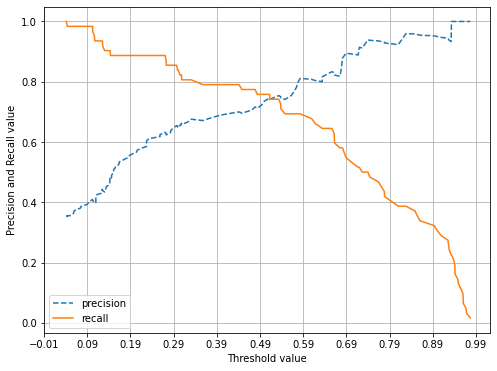

In [ ]:
#시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--',label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end =plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))

  # x축, y축 label과 legen, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임계값이 낮을수록 정밀도는 낮아지고 재현율은 높아진다.
- 임계값이 높을수록 정밀도는 높아지고 재현율은 낮아진다.



## 정밀도와 재현율의 맹점

Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경됩니다. 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 합니다. 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로는 사용돼서는 안됩니다. 

한번 정밀도 또는 재현율을 극단적으로 높여보겠습니다.
- 정밀도가 100%가 되는 방법
 : 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negativeㄹ 예측합니다. 예를 들어 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive, 그 외는 Negative로 예측하는 것입니다. 전체 환자 1000명 중 확실한 징우의 환자는 단 1명이라고 하면 이 한명만 Positive로 예측하고 나머지 999명은 Negative로 예측하더라도 FP는 0, TP는 1이므로 정밀도는 100%가 됩니다.

- 재현율이 100%가 되는 방법
  : 모든 환자를 Positive로 예측하면 됩니다. 전체환자 1000명을 다 Positive로 예측하는 것입니다. 이 중 실제 양성인 사람이 30명 정도라도 TN이 수치에 포함되지 않고 FN은 아예 0이므로 30/(30+0)으로 100%가 됩니다.

이처럼 어느 한쪽만 참조하면 극단적인 수치 조작이 가능합니다. 따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있습니다. 물론 앞의 예제에서와 같이 분류가 정밀도 또는 재현율 중 하나에 상대적인 중요도를 부여해 각 예측 상황에 맞는 분류 알고리즘을 튜닝할 수 있지만, 그렇다고 정밀도/재현율 중 하나만 강조하는 상황이 되어서는 안됩니다.(예를들어, 암 예측 모델에서 재현율을 높인다고 걸핏하면 양성으로 판단할 경우 환자의 부담과 불평이 커지게 됩니다.)

정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요합니다.

# F1 score

F1 스코어는 정밀도와 재현율을 결합한 지표이다. 정밀도와 재현율 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 F1 score는 상대적으로 높은 값을 가진다. 

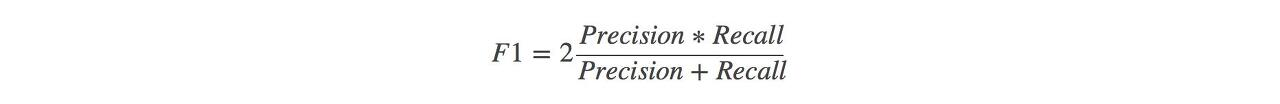

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7520


In [ ]:
# 임계값 변화 + F1 score

def get_clf_eval(y_test, pred) :
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy,precision,recall,f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값 : 0.4
오차행렬
[[95 22]
 [13 49]]
정확도:0.8045, 정밀도:0.6901, 재현율:0.7903, F1:0.7368

임곗값 : 0.45
오차행렬
[[97 20]
 [14 48]]
정확도:0.8101, 정밀도:0.7059, 재현율:0.7742, F1:0.7385

임곗값 : 0.5
오차행렬
[[101  16]
 [ 15  47]]
정확도:0.8268, 정밀도:0.7460, 재현율:0.7581, F1:0.7520

임곗값 : 0.55
오차행렬
[[103  14]
 [ 19  43]]
정확도:0.8156, 정밀도:0.7544, 재현율:0.6935, F1:0.7227

임곗값 : 0.6
오차행렬
[[107  10]
 [ 20  42]]
정확도:0.8324, 정밀도:0.8077, 재현율:0.6774, F1:0.7368


# ROC 곡선
 (Receiver Operation Characteristic Curve, 수신자 판단 곡선)

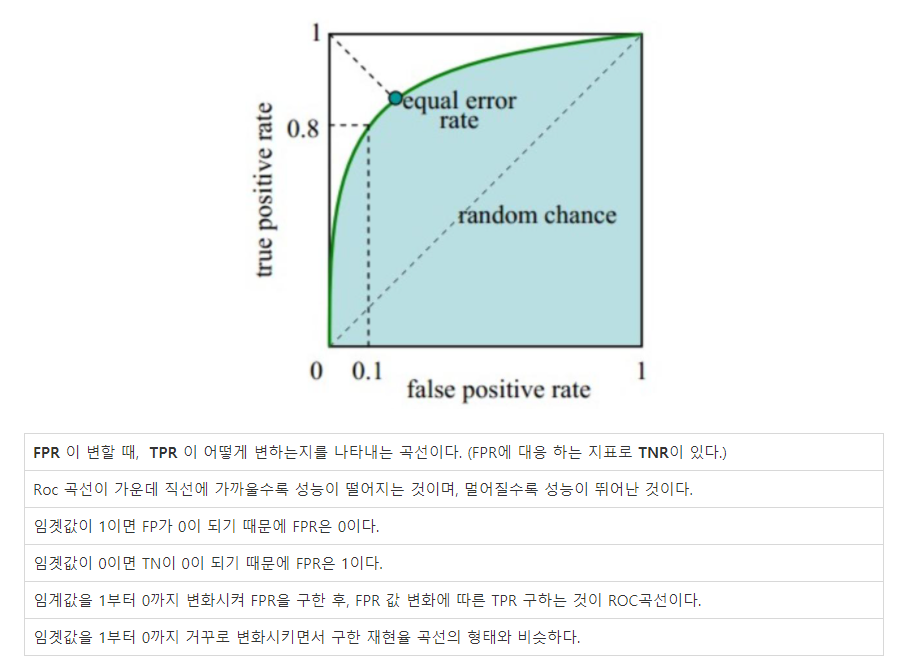

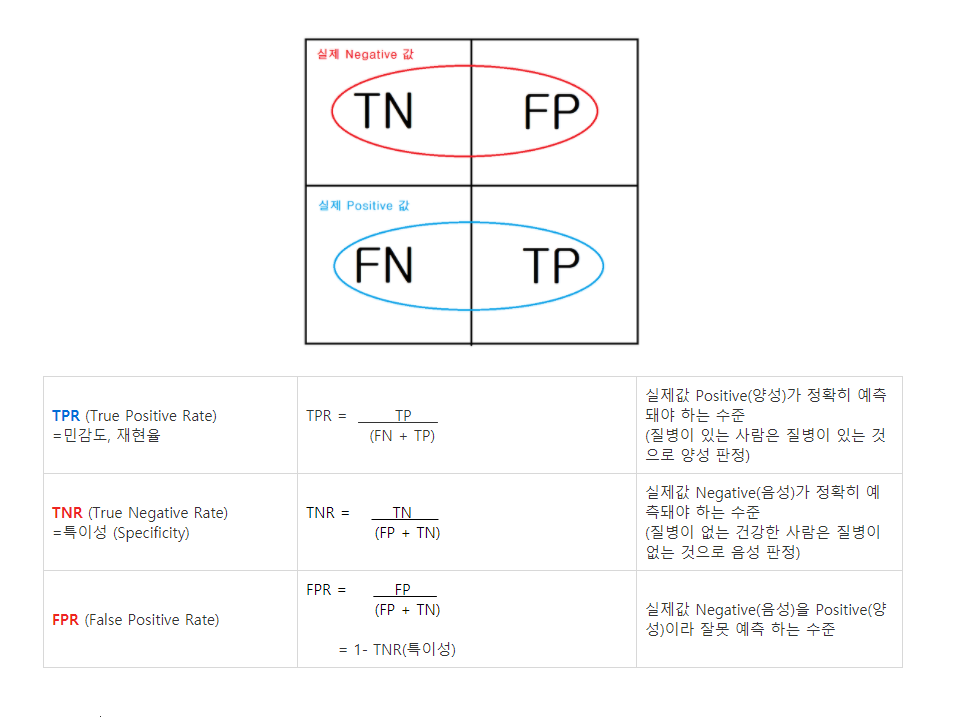

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일떄의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
#threshold[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arrange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR:',np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR:',np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.98 0.74 0.68 0.55 0.48 0.31 0.3  0.2  0.13 0.11 0.11]
샘플 임계값별 FPR: [0.    0.017 0.043 0.128 0.162 0.222 0.239 0.359 0.607 0.675 0.752]
샘플 임계값별 TPR: [0.016 0.5   0.581 0.694 0.774 0.806 0.855 0.887 0.903 0.935 0.935]


임곗값이 점점 작아지면 FPR이 커진다. 그리고 FPR이 조금씩 커질때 TPR은 가파르게 커짐을 알 수 있다.

# AUC(Area Under Curve)
ROC 곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치이다.

- AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 중요하다.
- 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할 수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워지는 좋은 ROC AUC성능 수치를 얻게 된다.
- 가운데 대각선 직선은 ACU값으로 0.5이다. 따라서 보통 분류의 AUC 값은 0.5 이상이다.

In [ ]:
from sklearn.metrics import roc_auc_score


pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.8679


모든 평가 지표를 구하는 함수

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)
  #ROC-AUC 추가
  roc_auc = roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f},\
         F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))